In [1]:
import xarray as xr
import numpy as np
import pylab as plt
import cartopy.crs as ccrs
import cmocean
import copy as cp
from scipy.interpolate import griddata, interp1d
import pickle
import glob
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.cm import get_cmap
import cartopy as cr
import matplotlib.cm as cm
from datetime import datetime as dtime
import matplotlib.colors as colors

# Bathymetry

In [2]:
def re_grid_fucking_ORCA(Aplot):
    # Make the new grid
    lons_1d=np.linspace(0, 360, 721)
    lats_1d=np.linspace(65, 90, 51)
    lons_2d, lats_2d = np.meshgrid(lons_1d, lats_1d)
    try:
        lons=Aplot.Lons_360.values
    except:
        lons = cp.deepcopy(Aplot.llon_cc.values)
        lons[lons<0] = lons[lons<0]+360
    try:
        lats=Aplot.llat_cc.values
    except:
        lats = Aplot.nav_lat.values
    temp=Aplot.values
    lons=lons.flatten()
    lats=lats.flatten()
    temp=temp.flatten()

    
    temp_new = griddata((lons, lats), temp, (lons_2d, lats_2d), method='linear')
    
    dint = xr.Dataset(data_vars = {'Lats_reg':lats_1d, 'Lons_reg_360':lons_1d})
    dint['val'] = (('Lats_reg', 'Lons_reg_360'), temp_new)
    return dint

In [3]:
# Load
ds_zgr =  xr.open_dataset('/storage/nplanat/Glorys12_masks/Mask_zgr_12.nc')
ds_zgr = ds_zgr.set_coords('nav_lat')
ds_zgr = ds_zgr.set_coords('nav_lon')
dsT = xr.open_dataset('/storage/nplanat/Glorys12_ORCA_mensuel/ext_arctic-GLORYS12V1_ORCA12_199408_gridT.nc')
dsT = dsT.set_coords('nav_lat')
dsT = dsT.set_coords('nav_lon')

Lons_360 = dsT.nav_lon.values
for x in range(dsT.nav_lon.shape[0]):
    for y in range(dsT.nav_lat.shape[1]):
        if Lons_360[x,y]<0:
            Lons_360[x,y] +=360
ds_zgr['Lons_360'] = (('y', 'x'), Lons_360)
ds_zgr = ds_zgr.set_coords('Lons_360')

bathy = re_grid_fucking_ORCA(ds_zgr.mbathy[0,:,:])

# Visualize raw data - no classif

In [4]:
files = sorted(glob.glob('/storage/nplanat/Glorys12_OP_journalier/ADV_new_*'))
files_m = sorted(glob.glob('/storage/nplanat/Glorys12_OP_journalier/ADV_m_200_*'))
files_s = sorted(glob.glob('/storage/nplanat/Glorys12_OP_journalier/ADV_s_200_*'))

In [14]:
L_j = []
for i in range(len(files)):
    L_j.append(xr.open_dataset(files[i]))

## Show some exemples

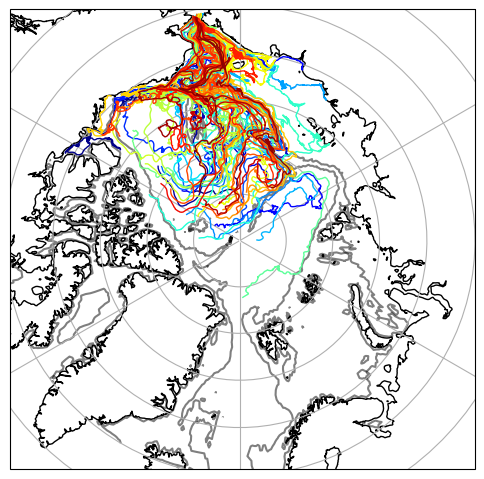

In [21]:
N = 100 #nmb of traj to plot
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1,  projection = ccrs.NorthPolarStereo())
ax.coastlines()
ax.gridlines()
cmap = plt.cm.jet(np.linspace(0,1,N))
for j in range(N):
    t = np.random.randint(len(files))
    n = np.random.randint(len(L_j[t].traj.values))
    ax.plot(L_j[t].lon.values[n, :], L_j[t].lat.values[n, :],  transform=ccrs.PlateCarree(), lw = 1, c= cmap[j])
ax.set_extent([-200, 90, 65, 90], crs=ccrs.PlateCarree())
bathy.val.plot.contour(alpha = 0.5, levels = [38, 22], colors = 'k',ax=ax, transform=ccrs.PlateCarree(), x='Lons_reg_360', y='Lats_reg', add_colorbar=False,  infer_intervals=True)       

## Density of particles on an EASE grid

### EASE grid

In [31]:
# Load ease grid
f = open('/storage/nplanat/DataObs/EASE-GRID/NLLATLSB', 'r')
NHLat25 =np.fromfile(f, dtype= np.int32)
f.close()
NHLat25 = NHLat25/100000
NHLat25[NHLat25==NHLat25[0]] = np.nan
NHLat25 = np.reshape(NHLat25, (721, 721), order = 'C')

f2 = open('/storage/nplanat/DataObs/EASE-GRID/NLLONLSB', 'r')
NHLon25 =np.fromfile(f2,dtype=np.int32)
f2.close()
NHLon25 = NHLon25/100000
NHLon25[NHLon25==NHLon25[0]] = np.nan
NHLon25 = np.reshape(NHLon25, (721, 721), order = 'C')

A = np.where(NHLat25>=65)

EASElat25 = NHLat25[np.min(A[0]):np.max(A[0])+1, np.min(A[1]):np.max(A[1])+1]
EASElon25 = NHLon25[np.min(A[0]):np.max(A[0])+1, np.min(A[1]):np.max(A[1])+1]


x25= np.arange(0, EASElat25.shape[0])
y25 = np.arange(0, EASElon25.shape[0])
XX25, YY25 = np.meshgrid(x25,y25)
X25 = np.reshape(XX25, XX25.shape[0]**2)
Y25 = np.reshape(YY25, YY25.shape[0]**2)
EASElat_flat25 = np.reshape(EASElat25, (EASElat25.shape[0]**2))
EASElon_flat25 = np.reshape(EASElon25, (EASElon25.shape[0]**2))
N_shape = EASElat25.shape[0]

def get_x_y25(ALat, Alon):
    Func_Inter_Ease2X = griddata(np.transpose(np.array([EASElat_flat25,EASElon_flat25])), X25, xi = np.transpose(np.array([ALat, Alon])), method= 'nearest')
    Func_Inter_Ease2Y = griddata(np.transpose(np.array([EASElat_flat25,EASElon_flat25])), Y25, xi = np.transpose(np.array([ALat, Alon])), method= 'nearest')
    return Func_Inter_Ease2X, Func_Inter_Ease2Y    

Ex, Ey = get_x_y25(EASElat_flat25, EASElon_flat25)
Elin = Ex + N_shape*Ey
def get_x_y_from_xy(xy, n = N_shape):
    return xy%n, xy//n

In [23]:
ds_EASE_25 = xr.Dataset(data_vars = {'xy':Elin})
ds_EASE_25['lat'] = (('xy'), EASElat_flat25)
ds_EASE_25['lon'] = (('xy'), EASElon_flat25)
ds_EASE_25['x'] = (('xy'), Ex)
ds_EASE_25['y'] = (('xy'), Ey)

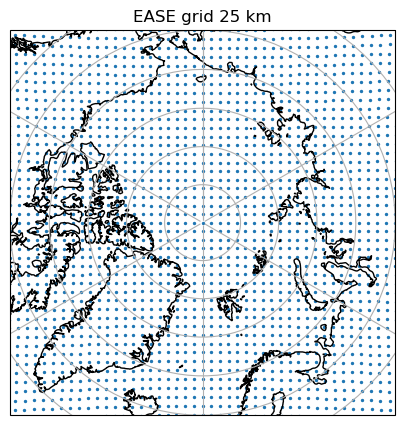

In [24]:
a = 5
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(1,1,1, projection = ccrs.NorthPolarStereo())
ax.coastlines()
ax.gridlines()
ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
ax.scatter(EASElon25[::a,::a], EASElat25[::a,::a], s = 2, transform =ccrs.PlateCarree() )
ax.set_title('EASE grid 25 km')
plt.show()

### Density datasets

In [ ]:
M_j = []
for t in range(len(L_j)):
    print(t, '/', len(L_j))
    ds = cp.deepcopy(L_j[0])
    XY = np.zeros(ds.lat.shape)
    for o in range(len(ds.obs.values)):
        ALat = ds.lat.values[:, o]
        ALon = ds.lon.values[:, o]
        ALat[np.isnan(ALat)] = 0
        ALon[np.isnan(ALon)] = 0
        ALon[ALon<-180] = ALon[ALon<-180]+360
        x, y = get_x_y25(ALat, ALon)
        XY[:, o] = x+N_shape*y
        ds['xy'] = (('traj', 'obs'), XY)
    DS = ds.groupby('xy').count()
    XY = DS.xy.values.astype(int)
    CO = DS.time.values
    M = np.zeros(EASElat25.shape)
    for (x,y, c) in zip(ds_EASE_25.x[XY].values, ds_EASE_25.y[XY].values, CO):
        M[y,x] = c
    M_j.append[M]

/storage/nplanat/MINICONDA/envs/analysis/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


Text(0, 0.5, 'Nmb particles')

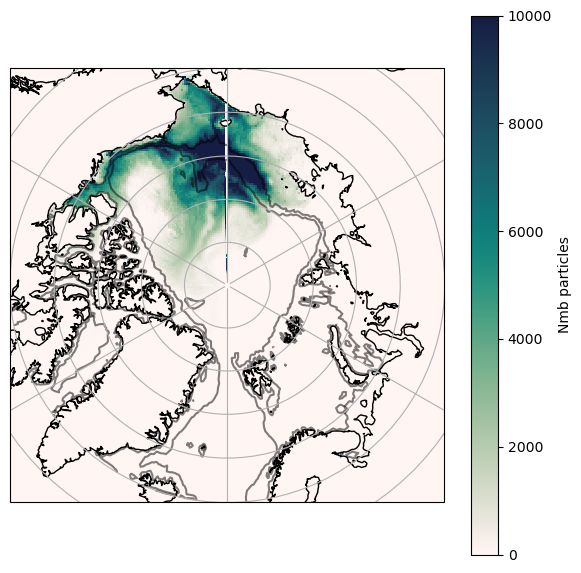

In [97]:
y = 0 # year index
fig = plt.figure(figsize = (7, 7))
ax = fig.add_subplot(1,1,1, projection =ccrs.NorthPolarStereo())
ax.gridlines()
ax.coastlines()
ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
im = plt.pcolormesh(EASElon25, EASElat25, M_j[y],vmax = 10000, transform=ccrs.PlateCarree(), cmap = cmocean.cm.tempo)
bathy.val.plot.contour(alpha = 0.5, levels = [22, 34], colors = 'k',ax=ax, transform=ccrs.PlateCarree(), x='Lons_reg_360', y='Lats_reg', add_colorbar=False,  infer_intervals=True)       
cbar = fig.colorbar(im)
cbar.ax.set_ylabel('Nmb particles')


# Sensibility to seeding

# Classif ML Visualisation

## Load

In [98]:
SUB_SETS = {'all':{'Subset_name':'/storage/nplanat/Glorys12_OP_journalier/NEW_RUN/Sub_samp_y_1993_-_2014_delta_1_100000_start_lon_0.nc',\
                  'init_year':1993,\
                  'final_year':2014,\
                   'delta_year':1,\
                  'N_particles':100000,\
                  'Subset_path':'/storage/nplanat/Glorys12_OP_journalier/NEW_RUN/'}}

In [99]:
# Load parameters
sel_subset = 'all'
load_previous_run = True
init_year = SUB_SETS[sel_subset]['init_year']
final_year = SUB_SETS[sel_subset]['final_year']
delta_year = SUB_SETS[sel_subset]['delta_year']
Subset_name = SUB_SETS[sel_subset]['Subset_name']
N_particles = SUB_SETS[sel_subset]['N_particles']
Subset_path = SUB_SETS[sel_subset]['Subset_path']

length_days = 600
path_save_prediction = Subset_path 


perctest = 0.1 
perctrain = 0.8
trans = True

#PCA 
n_components = 0.9999999

# Clustering
init = 'k-means++'
nmb_initialisations = 20  # number of initiatilisaton for the k-means++ 
max_iter = 500
tol = 5e-4
algorithm = 'full'
verbose = 0 
sample_weight = None
n_split = 20  # number of iterations for convergence
n_clusters = 20 #number of clusters

In [100]:
#load PCA : 
with open(Subset_path + 'pca.pkl', 'rb') as pickle_file:
    pca = pickle.load(pickle_file)
#load clustering : 
Traj_centroids = np.load(Subset_path+'Traj_centroids.npy', allow_pickle = True)
# load previous runs :
Labels_valid = np.load(path_save_prediction+'Labels_valid.npy')
Labels_test = np.load(path_save_prediction+'Labels_test.npy')
lats_test = np.load(path_save_prediction+'lats_test.npy')
lons_test = np.load(path_save_prediction+'lons_test.npy')
lats_train = np.load(path_save_prediction+'lats_train.npy')
lons_train = np.load(path_save_prediction+'lons_train.npy')
lats_valid = np.load(path_save_prediction+'lats_valid.npy')
lons_valid = np.load(path_save_prediction+'lons_valid.npy')

## Visalize

### All

In [101]:
def plot_density_arctic(labs, lons, lats, n_clusters, vmax):
    lims = [-200, -90, 65, 90]
    ncs = np.arange(n_clusters)
    Liste_hist  = []
    f = plt.figure(figsize = (15, 8))   

    for nc in ncs:
        print(nc)

        cf = 'k'

        lons_pdf = [] ; lats_pdf = [] ; count=0
        for n in range(len(labs)):
            if labs[n]==nc :
                lons_pdf.extend(lons[n,:][~np.isnan(lons[n,:])]) ; lats_pdf.extend(lats[n,:][~np.isnan(lats[n,:])])
                count += 1

        # Initalize the histogram
        lon1 = 0 ; lon2 = 360 ; lat1 = 65 ; lat2 = 90
        x = np.arange(lon1,lon2,1./12.)
        y = np.arange(lat1,lat2,1./12.)

        # Calculate the histogram
        hist, xe, ye = np.histogram2d(lons_pdf, lats_pdf, bins=(x,y))
        hist[hist==0] = np.nan

        # plot
        ax = f.add_subplot(np.max(labs)//6+1,6,nc+1, projection = ccrs.NorthPolarStereo())
        ax.coastlines(color='silver')
        ax.gridlines(zorder=-1)
        ax.set_extent(lims,  crs=ccrs.PlateCarree())
        ax.add_feature(cr.feature.LAND, linewidth=0.5, edgecolor='white')

        im = ax.pcolor(x, y, hist.T, norm=colors.LogNorm(vmin=1.0,vmax=vmax), transform = ccrs.PlateCarree(), cmap=get_cmap('hot_r'))
        ##im = ax.pcolor(x, y, hist.T, norm=colors.LogNorm(vmin=2.0,vmax=np.nanpercentile(hist,99)), transform = ccrs.PlateCarree(), cmap=get_cmap('hot_r'))
        Liste_hist.append(hist.T)
        ax.text(0.03, 0.05, '#'+str(nc), transform=ax.transAxes, fontsize=16)
        ax.text(0.8, 0.87, str(count), transform=ax.transAxes, fontsize=16)
        #plt.contour(lonb, latb, bathy, [350], colors='dimgrey', transform = ccrs.PlateCarree(), zorder=2)

        if nc==0:
            cbaxes = inset_axes(ax, width="50%", height="5%", loc=3) 
            cbar = plt.colorbar(im, cax=cbaxes, ticks=[0.,10,50], orientation='horizontal')
    return Liste_hist, f

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


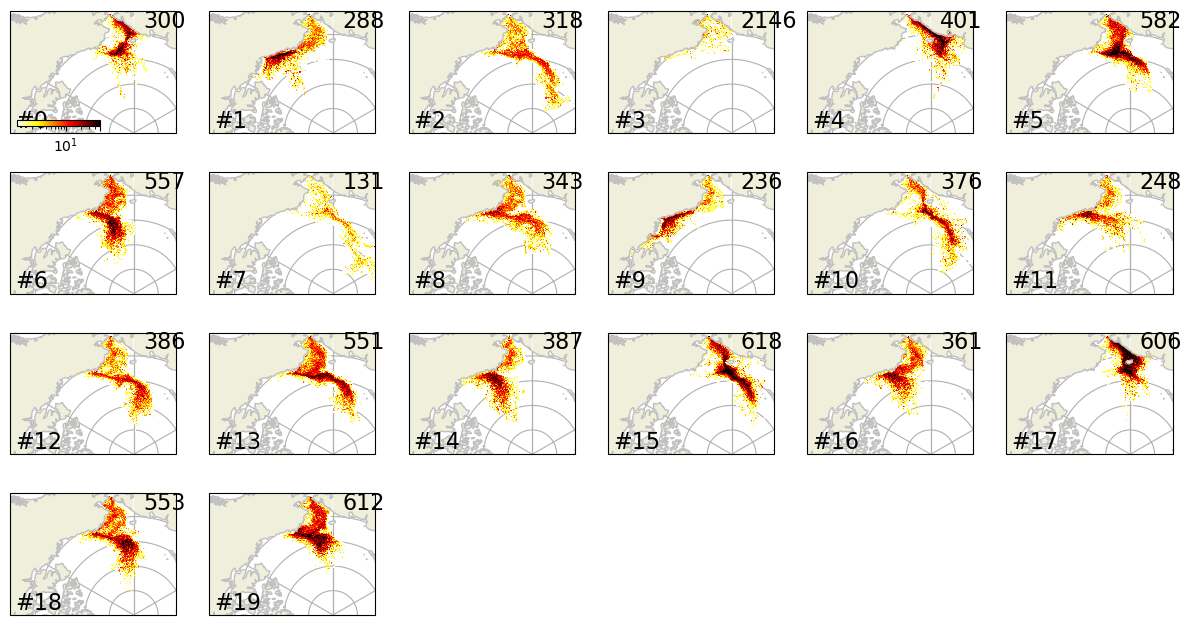

In [102]:
Hist_valid, f = plot_density_arctic(Labels_valid, lons_valid, lats_valid, n_clusters, vmax = 50)

In [114]:
def make_histo_arctic(labs, lons, lats, n_clusters):
    ncs = np.arange(n_clusters)
    Liste_hist  = []
    for nc in ncs:
        print(nc)

        cf = 'k'

        lons_pdf = [] ; lats_pdf = [] ; count=0
        for n in range(len(labs)):
            if labs[n]==nc :
                lons_pdf.extend(lons[n,:][~np.isnan(lons[n,:])]) ; lats_pdf.extend(lats[n,:][~np.isnan(lats[n,:])])
                count += 1

        # Initalize the histogram
        lon1 = 0 ; lon2 = 360 ; lat1 = 65 ; lat2 = 90
        x = np.arange(lon1,lon2,1./12.)
        y = np.arange(lat1,lat2,1./12.)

        # Calculate the histogram
        hist, xe, ye = np.histogram2d(lons_pdf, lats_pdf, bins=(x,y))
        hist[hist==0] = np.nan
        Liste_hist.append(hist.T)
    return Liste_hist

In [115]:
Liste_h = make_histo_arctic(Labels_valid, lons_valid, lats_valid, n_clusters)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


### Groups

In [103]:
def running_mean(t, x, N) :
    rm = np.convolve(x, np.ones((N,))/N, mode='valid')
    times = t[int(N/2):len(rm)+int(N/2)]
    return times, rm

In [104]:
L1 = [1, 9]#ACC
L2 = [2, 5, 7, 8, 10, 12, 13, 15]#Contourne BC
L3 = [4, 17]#eurasie
L4 = [6, 14, 16, 18, 19]# Entre CB
L5 = [0, 3] # Chukchi shelf
L6 = [11]#NWRidge
Groupes = [L1,L2,L3,L4,L5,L6]
Names = ['ACC', 'Contourne BC', 'Eurasie', 'Entre CB', 'Chukchi shelf', 'NW Ridge']

La = [6,18,19]
Lb = [14,16]

Groupes2 = [La, Lb]
Names2 = ['NW', 'Direct']

In [112]:
Dates_all = []; Perc_labels_all = [];
for yr in range(1993,2014):
    try:
        print('Year', yr)
        labs_yr = np.load(path_save_prediction+'labels_data_%i'%yr + '.npy', allow_pickle = True)
        time_yr = np.load('/storage/nplanat/Glorys12_OP_journalier/lats_lons/times_%i'%yr+'.npy', allow_pickle = True)
        Date_data = np.unique(time_yr)
        Dates_all.extend(Date_data)
        Perc_labels = np.zeros((len(Date_data), n_clusters))
        for i in range(len(Date_data)):
            d0 = np.where(Date_data[i] ==time_yr)[0]
            for di in d0:
                Perc_labels[i,labs_yr[di]] +=1
            Perc_labels[i,:] =100*Perc_labels[i,:]/len(d0)
        Perc_labels_all.extend(Perc_labels)
    except: 
        print('I miss year ', yr)
Perc_labels_all = np.array(Perc_labels_all)

Year 1993
Year 1994
Year 1995
Year 1996
Year 1997
Year 1998
Year 1999
Year 2000
Year 2001
Year 2002
Year 2003
Year 2004
Year 2005
Year 2006
Year 2007
Year 2008
Year 2009
Year 2010
Year 2011
Year 2012
Year 2013


groupe,  0
groupe,  1
groupe,  2
groupe,  3
groupe,  4
groupe,  5


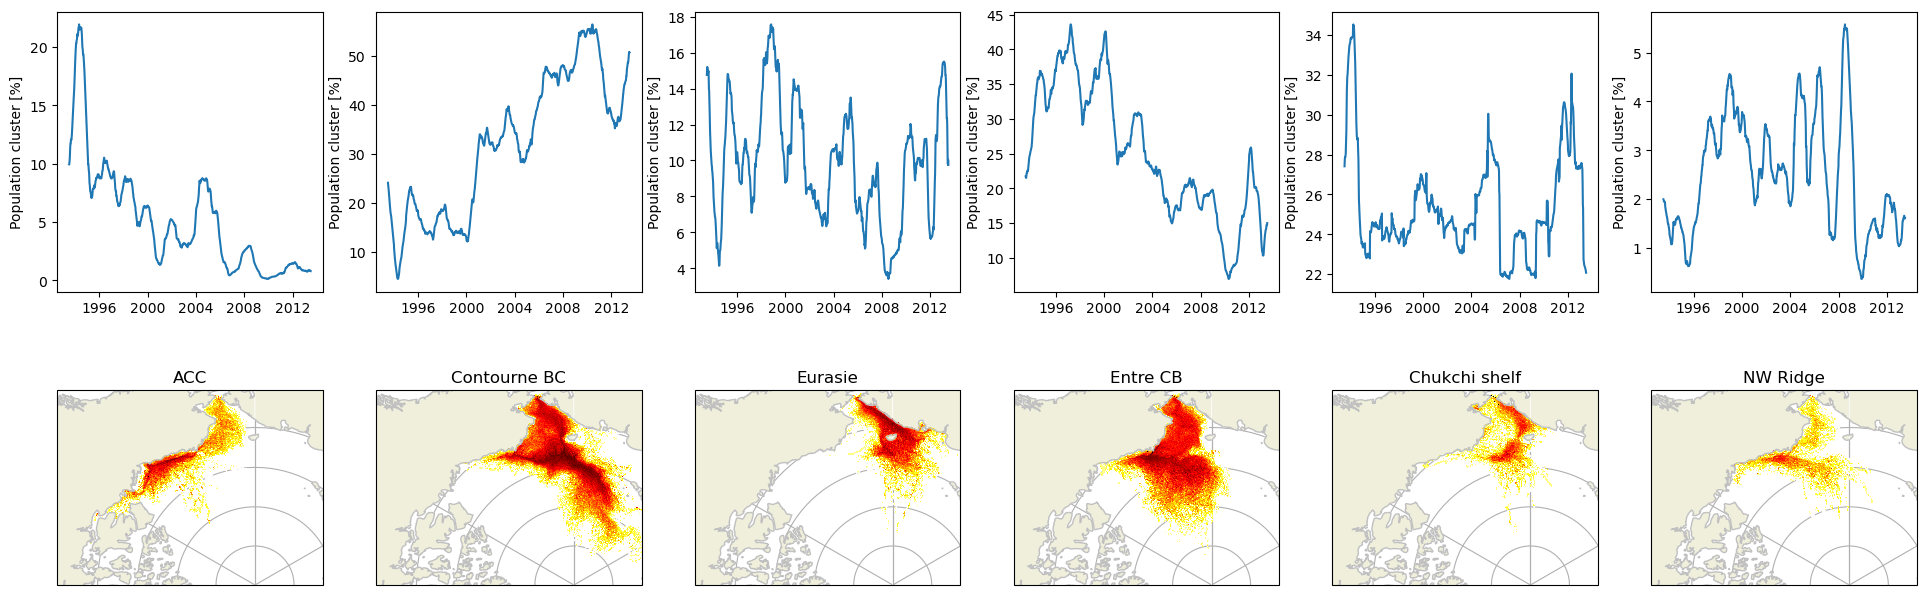

In [116]:
vmax = 300
f = plt.figure(figsize = (len(Groupes)*4, 8))
for i in range(len(Groupes)):
    print('groupe, ', i)
    ax = f.add_subplot(2,len(Groupes),i+1)
    #ax.plot(Dates_all, np.sum(Perc_labels_all[:,Groupes[i]], axis = 1))
    tm0,rm = running_mean(Dates_all, np.sum(Perc_labels_all[:,Groupes[i]], axis = 1), 53)
    ax.plot(tm0, rm)
    ax.set_ylabel('Population cluster [%]')
    ax = f.add_subplot(2,len(Groupes),len(Groupes)+i+1,projection  = ccrs.NorthPolarStereo())
    # Initalize the histogram
    lon1 = 0 ; lon2 = 360 ; lat1 = 65 ; lat2 = 90
    x = np.arange(lon1,lon2,1./12.)
    y = np.arange(lat1,lat2,1./12.)
    lims = [-200, -90, 65, 90]
    ax.coastlines(color='silver')
    ax.gridlines(zorder=-1)
    ax.set_extent(lims,  crs=ccrs.PlateCarree())
    ax.add_feature(cr.feature.LAND, linewidth=0.5, edgecolor='white')
    A = np.nansum(np.array(Liste_h)[Groupes[i],:,:], axis = 0)
    #count = np.round(np.nansum(np.array(Liste_h)[Groupes[i],:,:])/1000000, 2)
    im = ax.pcolormesh(x, y, A, norm=colors.LogNorm(vmin=1.0,vmax=vmax), transform = ccrs.PlateCarree(), cmap=get_cmap('hot_r'))
    ax.set_title(Names[i])
#f.savefig('../Figures_Clustering/Figures/'+sel_subset+'/Arctic_groups_'+str(yr)+'.png', transparent=False)
#plt.close()

groupe,  0
groupe,  1


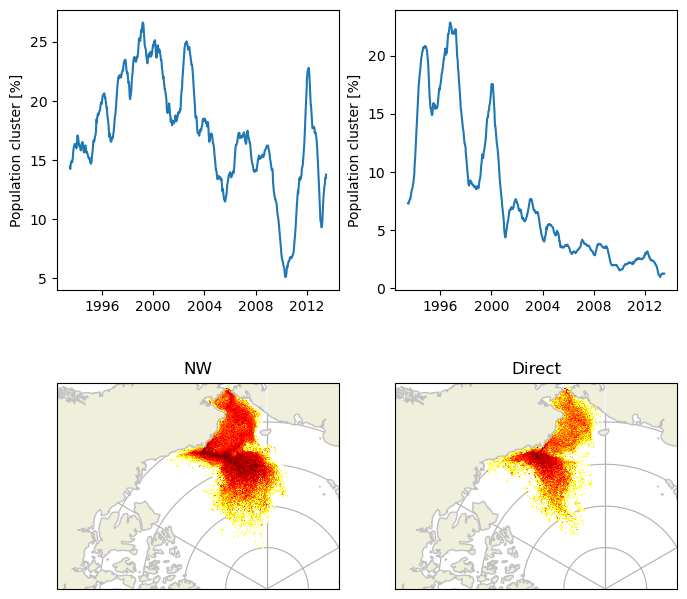

In [117]:
vmax = 200

#Liste_h = make_histo_arctic(Labels_valid, lons_valid, lats_valid, n_clusters)
f = plt.figure(figsize = (len(Groupes2)*4, 8))
for i in range(len(Groupes2)):
    print('groupe, ', i)
    ax = f.add_subplot(2,len(Groupes2),i+1)
    #ax.plot(Dates_all, np.sum(Perc_labels_all[:,Groupes[i]], axis = 1))
    tm0,rm = running_mean(Dates_all, np.sum(Perc_labels_all[:,Groupes2[i]], axis = 1), 53)
    ax.plot(tm0, rm)
    ax.set_ylabel('Population cluster [%]')
    ax = f.add_subplot(2,len(Groupes2),len(Groupes2)+i+1,projection  = ccrs.NorthPolarStereo())
    # Initalize the histogram
    lon1 = 0 ; lon2 = 360 ; lat1 = 65 ; lat2 = 90
    x = np.arange(lon1,lon2,1./12.)
    y = np.arange(lat1,lat2,1./12.)
    lims = [-200, -90, 65, 90]
    ax.coastlines(color='silver')
    ax.gridlines(zorder=-1)
    ax.set_extent(lims,  crs=ccrs.PlateCarree())
    ax.add_feature(cr.feature.LAND, linewidth=0.5, edgecolor='white')
    A = np.nansum(np.array(Liste_h)[Groupes2[i],:,:], axis = 0)
    #count = np.round(np.nansum(np.array(Liste_h)[Groupes[i],:,:])/1000000, 2)
    im = ax.pcolormesh(x, y, A, norm=colors.LogNorm(vmin=1.0,vmax=vmax), transform = ccrs.PlateCarree(), cmap=get_cmap('hot_r'))
    ax.set_title(Names2[i])
#f.savefig('../Figures_Clustering/Figures/'+sel_subset+'/Arctic_groups_'+str(yr)+'.png', transparent=False)
#plt.close()

# Comparison with Classic

# Influence of time resolution

# Temporal variability